# Classical: TfidfVectorizer

### Simon Mauquoi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn 
print(sklearn.__version__)

1.0.2


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
speech = pd.read_csv("cleaned_speeches.csv")
speech.head()

,Date,President,Party,Title,Transcript
0,1829-03-04,Andrew Jackson,0,First Inaugural Address,Fellow Citizens: About to undertake the arduou...
1,1829-05-11,Andrew Jackson,0,Proclamation Regarding Duties on Austrian Vessels,Whereas by an act of the Congress of the Unite...
2,1829-12-08,Andrew Jackson,0,First Annual Message to Congress,Fellow citizens of the Senate and House of Rep...
3,1830-05-06,Andrew Jackson,0,Message Regarding Treaties with the Choctaw Na...,To the Senate of the United States. The accomp...
4,1830-05-27,Andrew Jackson,0,Veto Message Regarding Funding of Infrastructu...,To the House of Representatives. I have mature...


## Pipeline

In [4]:
y = speech.Party
X = speech.Transcript
X.shape, y.shape

((867,), (867,))

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, shuffle=True, random_state=48)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((693,), (174,), (693,), (174,))

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

vect = TfidfVectorizer()
scaler = MaxAbsScaler() # also works with sparse data which is the case for output of vectorizer
clf = SGDClassifier(random_state=48)

pipe = make_pipeline(vect, scaler, clf)

In [7]:
pipe.named_steps

{'tfidfvectorizer': TfidfVectorizer(),
 'maxabsscaler': MaxAbsScaler(),
 'sgdclassifier': SGDClassifier(random_state=48)}

In [8]:
params = [{
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet'],
    'sgdclassifier__loss': ['hinge', 'log', 'perceptron'] # with hinge it's an svm, with log it's logistic regression
    }]

In [9]:
gs = GridSearchCV(pipe, params, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('maxabsscaler', MaxAbsScaler()),
                                       ('sgdclassifier',
                                        SGDClassifier(random_state=48))]),
             n_jobs=-1,
             param_grid=[{'sgdclassifier__loss': ['hinge', 'log', 'perceptron'],
                          'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet'],
                          'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)]}],
             scoring='f1_macro', verbose=1)

In [10]:
gs.best_estimator_

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('maxabsscaler', MaxAbsScaler()),
                ('sgdclassifier',
                 SGDClassifier(loss='log', penalty='elasticnet',
                               random_state=48))])

In [11]:
gs.best_score_

0.8608456576011057

In [12]:
gs.best_params_

{'sgdclassifier__loss': 'log',
 'sgdclassifier__penalty': 'elasticnet',
 'tfidfvectorizer__ngram_range': (1, 2)}

In [13]:
y_test_pred = gs.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84        87
           1       0.86      0.80      0.83        87

    accuracy                           0.84       174
   macro avg       0.84      0.84      0.84       174
weighted avg       0.84      0.84      0.84       174



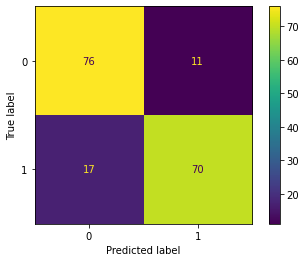

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred);